<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: Histograms and PDFs</h1>
### Notebook contributed by Leo Siqueira

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Ways of estimating a PDF from some numbers
1. <a href="#histograms">Histograms</a>
1. <a href="#kernels">Kernels</a>

In [13]:
import matplotlib as mpl
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4
from IPython.display import display, Math, Latex
from numpy.random import rand
from pylab import rcParams, pcolor, show,colorbar, xticks, yticks, title, figure
from IPython.display import Image
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

## Making a scatterplot is probably one of the most useful (at least initially) ways of visualizing my data...

#### At least, the most useful besides plotting on a map, given that the data is from a flight and doesn't give strong correlations without some massaging*.  I went ahead and just chose two variables from the humongous data set and compared them against eachother as well as in vertical profiles.



###### ~~*this is why I don't have a more useful comparison like AOD vs. Potential Temperature, which would tell me something for this campaign about what happens to the environment near the cloud when more biomass burning aerosol is present~~

In [14]:
# Define a figure: scatterplot. 

# this creates a figure and sets the size of it
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
rcParams['figure.figsize'] = (11, 6.5)

#this defines the figure, says it's just one plot (not subplots), prepares to plot the x and y data with "." markers,
#and labels the axes
def fig1():
    fig,ax=plt.subplots(1,1)
    ax.plot(theta1,lwc,'.')
    ax.set_xlabel('Potential Temperature (K)'); ax.set_ylabel('LWC (g/kg)')
    ax.set_title('Potential Temperature vs. LWC')
def fig2():
    fig,ax=plt.subplots(1,1)
    ax.plot(theta,alt,'.')
    ax.set_xlabel('Potential Temperature (K)'); ax.set_ylabel('Altitude (m)')
    ax.set_title('Potential Temperature vs. Altitude')
def fig3():
    fig,ax=plt.subplots(1,1)
    ax.plot(lwc,alt1,'.')
    ax.set_xlabel('LWC (g/kg))'); ax.set_ylabel('Altitude (m)')
    ax.set_title('LWC vs. Altitude')

In [15]:
# Import some data:
# Select a file to uploadquoting = csv.QUOTE_NONE

file = '..\..\data\mpo624_data2.csv'
data = np.genfromtxt(file,delimiter=',',dtype=None,encoding=None,names=True)  # 4 columns, 't', 'alt_m', 'ext530', and 'theta'    

t = data['t']
alt = data['alt_m']
lwc = data['lwc']
theta = data['theta']

# Trim the data to remove NaNs because python doesn't like them in jpdf calculations and finding a solution in that part,
# while preferable, is harder and I don't currently have the time or patience.

t1 = t[~np.isnan(lwc)]
alt1 = alt[~np.isnan(lwc)]
theta1 = theta[~np.isnan(lwc)]
lwc = lwc[~np.isnan(lwc)]

# do the same but based on NaNs w/in theta instead of lwc
t1 = t1[~np.isnan(theta1)]
alt1 = alt1[~np.isnan(theta1)]
lwc = lwc[~np.isnan(theta1)]
theta1 = theta1[~np.isnan(theta1)]

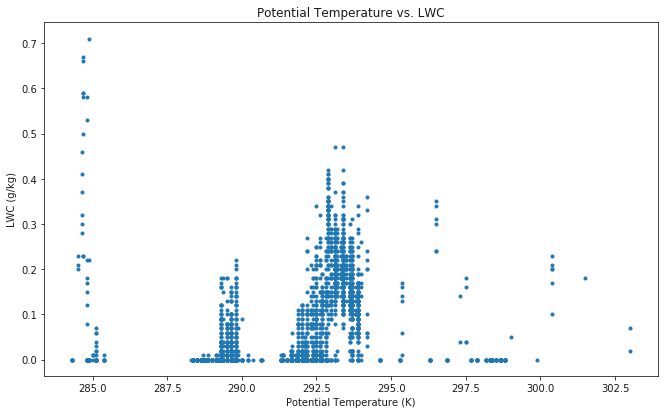

In [16]:
# PLOT IT
fig1()


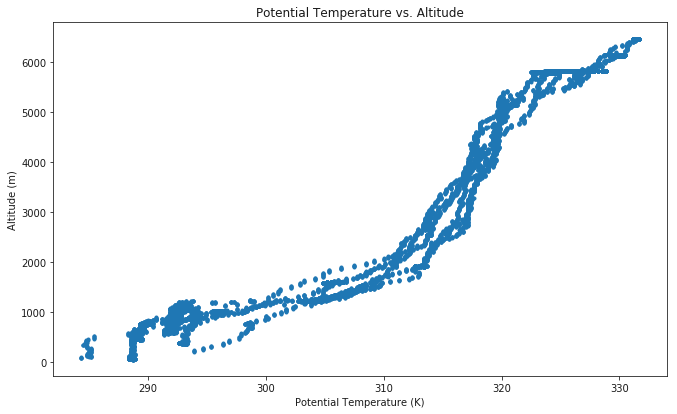

In [17]:
# PLOT IT
fig2()


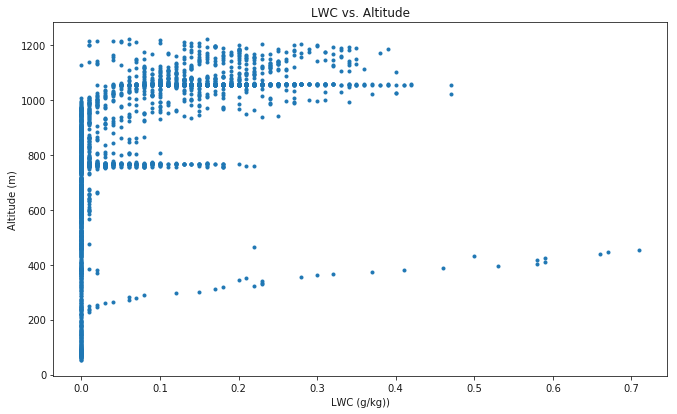

In [18]:
# PLOT IT
fig3()


###### So mostly these are just common sense, potential temperature increases with height, as one would expect based on its definition, and the vertical profile of LWC shows the approximate height of the cloud deck sampled.  It's hard to draw conclusions from any of this about anything though, especially with a variable like LWC that is spatially dependent in latitude and longitude as well.  Really, the only thing you can say about the first plot of potential temp against LWC is that you see higher clusters of LWC values where the potential temperature correspond to the heights shown in the third plot.  Which I suppose is a long-winded way of saying it's basically redundant and pointless.  Woohoo.

# "Ok, but what about those JPDF's tho?"

### Alright, well let's do this one at a time so we can see what best shows the data I guess...

###### (I'm gonna just stick with the vertical profile for PT from here on though)

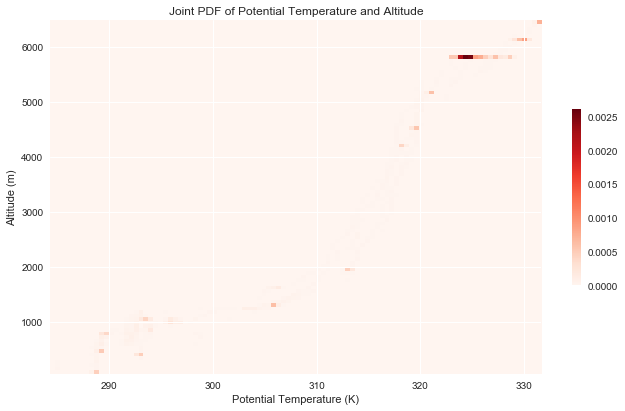

In [22]:
import matplotlib.cm as cm  # import the colormaps.
fig,ax=plt.subplots(1,1)    # Create a result-shaped container (a fig)

# Make the 2D histogram with 100 bins
x = theta
y = alt
(n,xx,yy,im)=ax.hist2d(x,y,bins=100,cmap=cm.Reds,cmin=0.,normed=True)

# Plot it, with a colorbar
plt.colorbar(im,shrink=0.5)
ax.set_xlabel('Potential Temperature (K)'); ax.set_ylabel('Altitude (m)')
ax.set_title('Joint PDF of Potential Temperature and Altitude')
plt.show()

### "Hmmmm... that...  That looks like absolutely nothing.  Are you sure these are even related???"

![alt text](https://img.buzzfeed.com/buzzfeed-static/static/2017-09/13/14/asset/buzzfeed-prod-fastlane-02/anigif_sub-buzz-13011-1505327302-9.gif)

#### Number two, yeah man.  Real deal.  But you have a point asthetically.  It isn't really showing the contrast between related and not related well and I don't exactly dig this red/pink scheme...

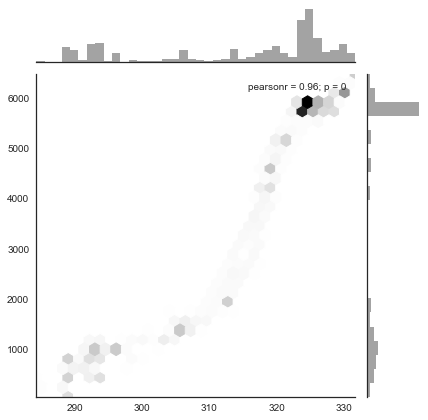

In [23]:
# Do it in Seaborn, with the marginal distributions on the top and side
import seaborn as sns
sns.set(color_codes=True)

df = pd.DataFrame({'x': x, 'y': y})
with sns.axes_style("white"):
    sns.jointplot(x=x, y=y, kind="hex", color="k");

#### Ahhhh yessss.  Much better.  It's actually looking a little like the Japanese archipelago, no?
![alt text](http://upload.wikimedia.org/wikipedia/commons/thumb/0/01/Japan_topo_en.jpg/325px-Japan_topo_en.jpg)

#### BUT, I bet we could do better.  Those grey hexagons are still a little hard to distinguish.

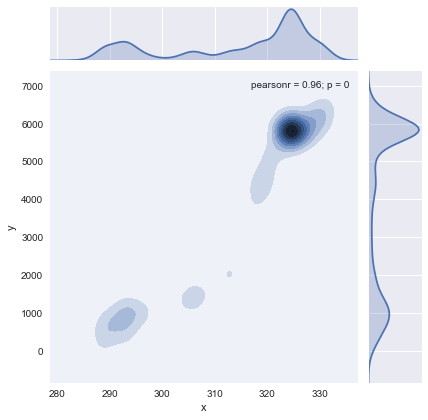

In [24]:
sns.jointplot(x="x", y="y", data=df, kind="kde")

#### Great!  So what does it mean???  Well...  Really not much from this particular graph except that the atmosphere wasn't doing anything super weird.  You might be asking though, "Why isn't it just a big, long blob of interconnectedness?  Does this mean that the PT jumps straight from 310K to 320K?"

![alt text](https://static1.fjcdn.com/thumbnails/comments/Theycallmesatan+rolled+image+_e2df98d7a68fba189a7aaf57e79c517c.png)

#### Nah, man.  That's just an artifact caused by the flight path.  The plane just didn't spend as much time at those altitudes.  Let's use this one on LWC with height though.  Just for kicks.


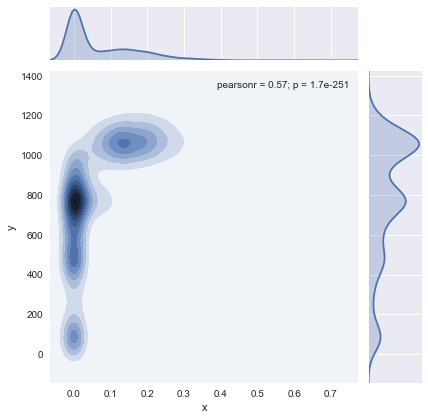

In [33]:
sns.jointplot(x="x", y="y", data=df, kind="kde")

![alt text](http://media2.giphy.com/media/c5PHIq9sXsV6o/giphy.gif)

####  See, what I like about this one is that it actually does filter out that little spike you could see in the original scatter plot.  If I didn't know ahead of time where the cloud was approximately, this would confirm that yes, there was a cloud deck around 1km, and that little spike wasn't significant over the entire course of the flight at least.